### SUICIDE RATE ANALYSIS

**Authors**
1. Linda Chang (wenlingc) <br>
2. Diksha Boruah (dboruah)

**Motivation**:<br>
The death of comedian and Hollywood actor Robin Williams shocked the world in 2014. He had committed suicide by hanging himself in his Paradise Cay, California home. Is it even fair that a person capable of spreading so much joy and laughter, to die in a way he had? He is just one in a million people who are not able to battle the temptations of death and end up committing suicide.

**Key takeaway**:<br>
- Globally 3M people die from suicide every year – that’s twice the number from homicide
- Globally, the suicide rate for men is twice as high as for women. In many countries this ratio is even higher
- Suicide rates are typically higher for older individuals
- There is no clear correlation between GDP and suicide rate

**Problem Statement:**<br>
Analysis of suicide data around the globe <br>

**Goal:** <br>
To idenitfy target areas by continent, coutry, gender, age and sex <br>

**Datasets**: <br>
- https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016
- https://www.amnesty.org/en/what-we-do/death-penalty/

Using the dataset available in https://www.amnesty.org/en/what-we-do/death-penalty/ to see causes of death among people (analysis done in Tableau)

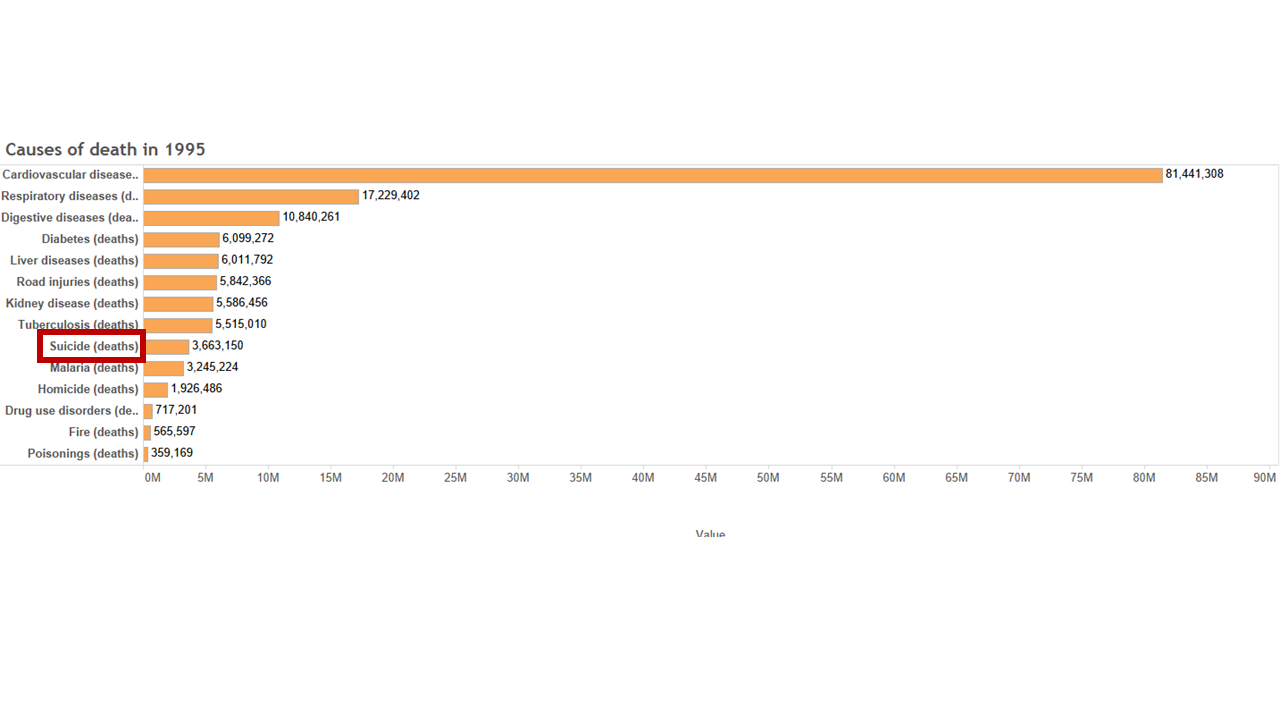

In [49]:
from IPython.display import Image
Image(filename='img/slide2.png',height=800,width=800)

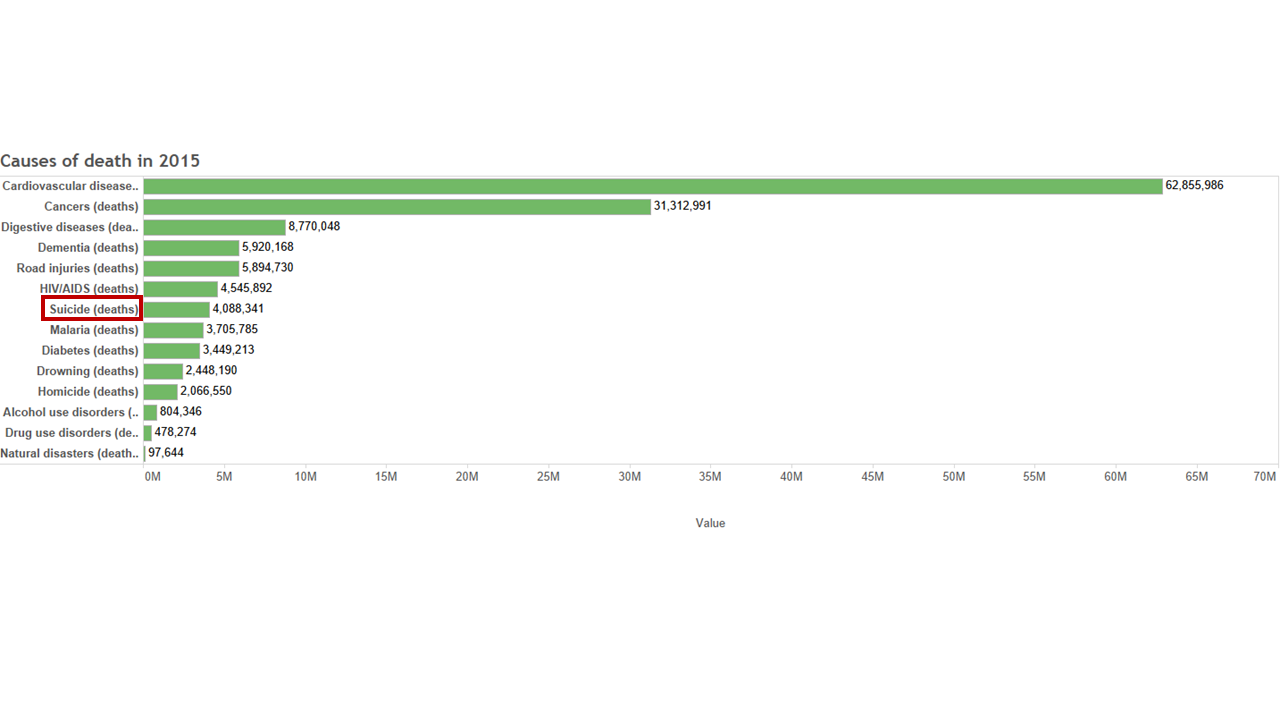

In [50]:
from IPython.display import Image
Image(filename='img/slide3.png',height=800,width=800)

### Reading the dataset

In [51]:
#importing some useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import seaborn as sns
%config InlineBackend.figure_format = 'retina' #for mac users 
plt.style.use("seaborn")
import geonamescache # geonamescache  provides data for conutries and contitents

In [52]:
original_dataset = pd.read_csv('master.csv')

In [53]:
original_dataset.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


**Dataset Description**: <br>
1. Total columns: 11 <br>
2. Countries: 101 <br>
3. Years: 1985-2016 <br>
4. Sex: Male, female<br>
5. Age: 5-14 years,15-24 years, 25-34 years, 35-54 years, 55-74 years, 75+ years<br>
6. Generation: G.I. Generation, Silent, Boomers, Generation X, Millennials, and Generation Z <br>


**Cleaning the data:**<br>
1. renaming some of the columns<br>
2. dropping country-year since it is redundant<br>
3. changing datatype of gdp_for_year from string to float <br>
4. dropping data for 2016 due to incomplete data

In [54]:
dataset = original_dataset.copy() #creating a copy of the oroginal dataset
dataset.rename(columns={'suicides_no':'total_suicides',
                        'suicides/100k pop':'suicides_per_100k',
                        ' gdp_for_year ($) ':'gdp_for_year',
                        'gdp_per_capita ($)':'gdp_per_capita',
                        'HDI for year': 'HDI_for_year'}, inplace=True)

dataset = dataset.drop('country-year', axis=1)

# gdp per year are strings.>float
dataset.gdp_for_year = dataset.gdp_for_year.apply(lambda x: float(''.join(x.split(','))))

# Removing the year 2016 
dataset = dataset.query('year != 2016')


The code below tries to map countries with the continents and fix the naming issues of countries (since some countries
have different names in the datset and module)

In [55]:
gc = geonamescache.GeonamesCache()
countries = gc.get_countries()
continent = {}
for k,v in countries.items():
    name = v['name']
    continentcode = v['continentcode']
    continent[name] = continentcode


continent["Macau"] = continent.pop("Macao")
continent["Czech Republic"] = continent.pop("Czechia")
continent["Republic of Korea"] = continent.pop("South Korea")
continent["Russian Federation"] = continent.pop("Russia")
continent["Saint Vincent and Grenadines"] = continent.pop("Saint Vincent and the Grenadines")

dataset['continentcode']= dataset['country'].map(continent)
dataset['continentcode'] = dataset['continentcode'].replace({'EU':'Europe',
                                                       'AS':'Asia',
                                                       'NA':'North America',
                                                       'SA':'South America',
                                                       'AF':'Africa',
                                                       'OC':'Oceania'})
dataset.rename(columns = {'continentcode':'continent'},inplace = True)

### EDA

### 1. Overview of suicide rate across the globe

[Text(0, 0.5, 'Suicide Rate'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Suicide Rate by Year across globe')]

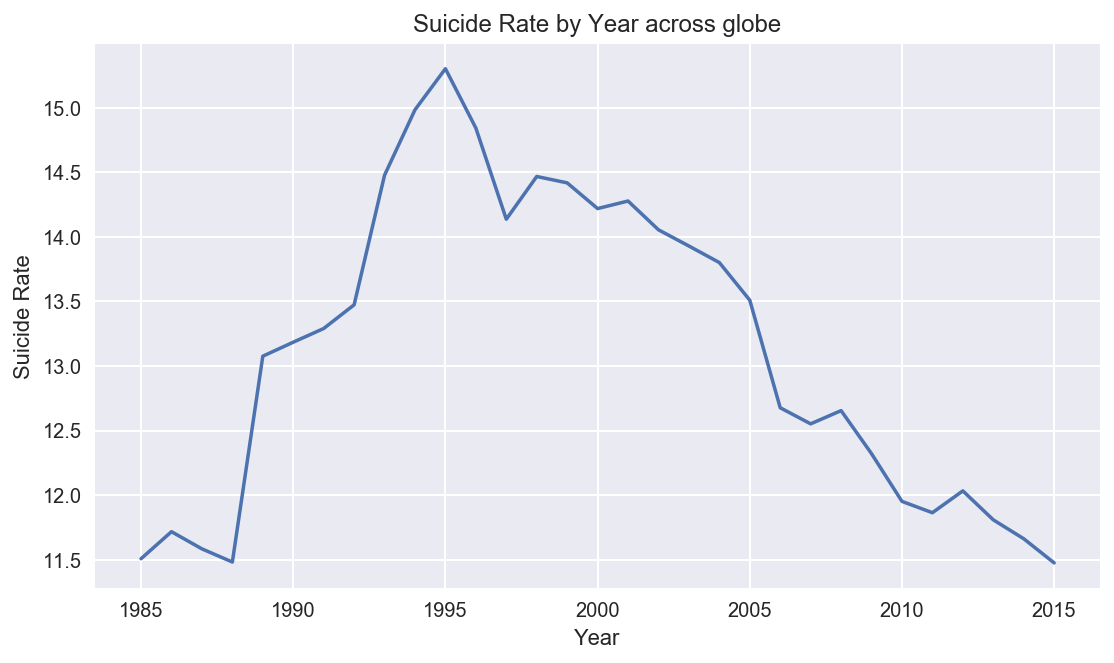

In [56]:
#0.0. Suicide rate accrose globe
plt.figure(figsize=(9,5))
by_year = dataset.groupby(['year'])[['population','total_suicides']].sum().reset_index()  
#another dataframe-year population, and total_suicide numbers
by_year['suicide_rate'] = by_year['total_suicides']*100000/by_year['population'] #suicide rate: base on 100K
ax = sns.lineplot(x="year", y="suicide_rate",data=by_year)
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Suicide Rate by Year across globe')

**Observation:** There is a steep increase in suicide rate in 1995 which is also the peak of the graph , followed by a steady decline thereafter. Suicide rate across the declining which is a good sign

In the analysis below we are trying to compare suicide rates and total suicides committed, in a country, in 1995, to any 
arbitrary year before 1995 (1991 in this case). Then we sort the data and see the top changes in suicide rates<br>

In [57]:
country_year_gb = dataset.groupby(['country', 'year'],
                                  as_index=False).sum()[['country', 'year',
                                                         'total_suicides', 'population']]

country_year_gb['Suicides_per_100k'] = 1e5 * country_year_gb['total_suicides'] / country_year_gb['population']

nnfive = country_year_gb.query("year in [1991, 1995]").pivot_table(index='country',
                                                                   columns='year',
                                                                   values=['total_suicides',
                                                                           'Suicides_per_100k'],
                                                                   aggfunc='sum')

nnfive['Changes in Number of Suicides'] = (nnfive.iloc[:,3] - nnfive.iloc[:,2])

nnfive.sort_values('Changes in Number of Suicides', ascending=False)[:6]

Suicides_per_100k            total_suicides           \
year                            1991       1995           1991     1995   
country                                                                   
Russian Federation         28.613157  43.532434        39281.0  60548.0   
Ukraine                    22.198894  30.033894        10700.0  14541.0   
Republic of Korea           7.673709  11.505262         3069.0   4841.0   
Kazakhstan                 20.611524  31.395101         3082.0   4706.0   
Japan                      16.934642  17.954448        19780.0  21249.0   
Brazil                      3.839685   4.514324         5156.0   6536.0   

                   Changes in Number of Suicides  
year                                              
country                                           
Russian Federation                       21267.0  
Ukraine                                   3841.0  
Republic of Korea                         1772.0  
Kazakhstan                                1624.0  
Japan                                     1469.0  
Brazil                                    1380.0

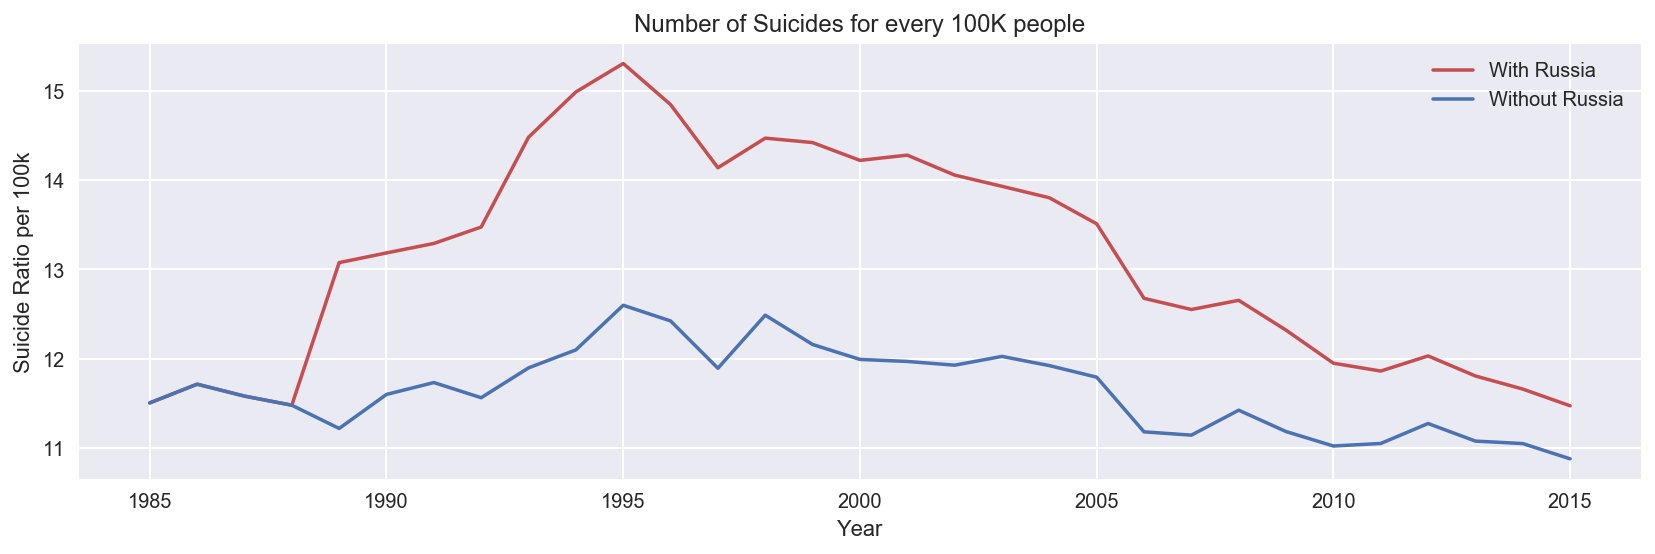

In [58]:
#Exclude Russia
plt.figure(figsize=(14,4))
exclude_ru = dataset[dataset.country !='Russian Federation']
exclude_ru_by_year = exclude_ru.groupby(['year'])[['population','total_suicides']].sum().reset_index()  
exclude_ru_by_year['Suicides_100k_2'] = 1e5 * exclude_ru_by_year['total_suicides']/exclude_ru_by_year['population']

global_num = dataset.copy()
global_num_by_year = global_num.groupby(['year'])[['population','total_suicides']].sum().reset_index()  

global_num_by_year['Suicides_100k_2'] = 1e5 * global_num_by_year['total_suicides']/global_num_by_year['population']

ax = sns.lineplot(x="year", y="Suicides_100k_2",color='r',data=global_num_by_year)
ax = sns.lineplot(x="year", y="Suicides_100k_2",color='b', data=exclude_ru_by_year)

ax.set(ylabel='Suicide Ratio per 100k', xlabel='Year', title = 'Number of Suicides for every 100K people')
ax.legend(labels=["With Russia","Without Russia"])

**Observation**: <br>
- The changes in number of suicide rate is very high from 1991 to 1995. This means that Russia had the highest contribution to the peak of the curve as observed before. <br>
- Official Russian economic statistics indicate that from 1990 to the end of 1995, Russian GDP declined by roughly 50 percent, far greater than the decline that the United States experienced during the Great Depression. <br>
 http://countrystudies.us/russia/58.htm<br>
- We are suspecting a correlation between GDP to suicide rate here (more EDA on this later).

### 2. Analysis of suicide rate by continent

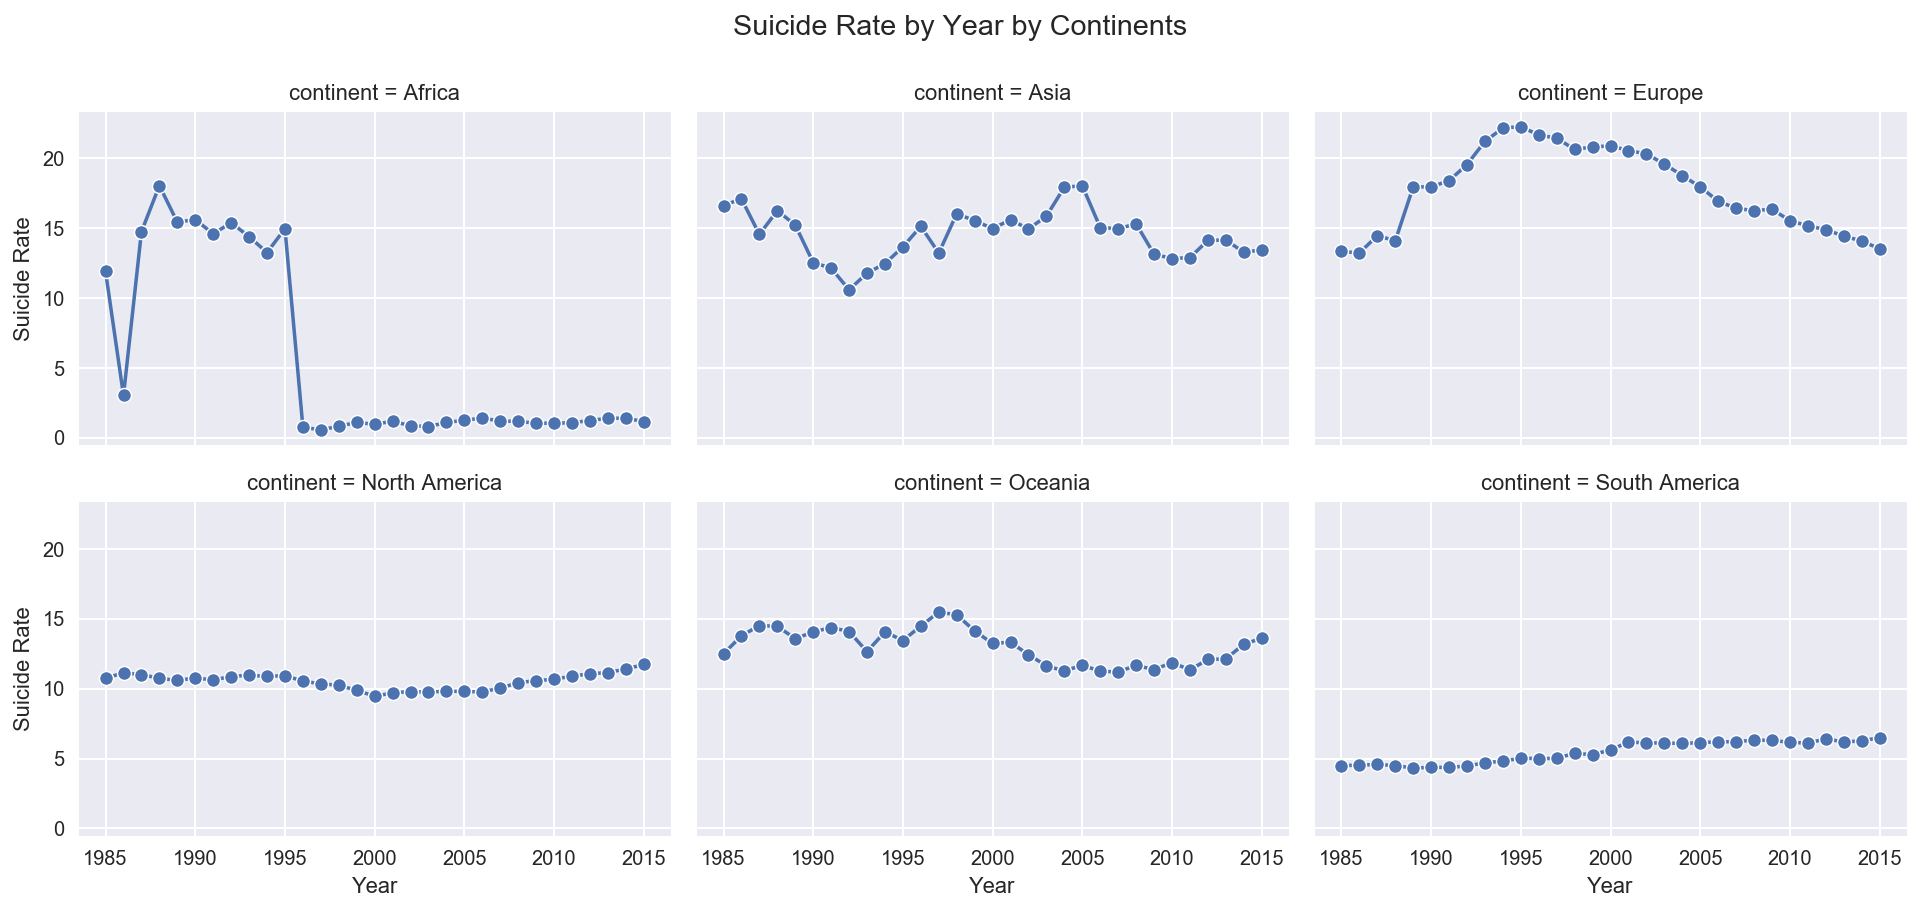

In [59]:

by_continent = dataset.groupby(['year','continent'])[['total_suicides','population']].sum().reset_index()
by_continent['suicide_rate'] = by_continent['total_suicides']*100000/by_continent['population'] #suicide rate: base on 100K

sns.set_style("darkgrid")
ax = sns.relplot(x="year", y="suicide_rate", col="continent",col_wrap=3,
                 data=by_continent , kind="line", legend="full", marker='o',
                height=3, aspect=1.5)
ax.set(ylabel='Suicide Rate', xlabel='Year')
ax.fig.suptitle('Suicide Rate by Year by Continents', x=0.5, y=1.05)
plt.show()

**Observation**: From the graphs above it can be seen that the suicide rate from Europe is really high. Both the starting point and ending point are high and the peak of the curve is also the highest for European continent

### 3. Analysis of suicide rate in the European countries

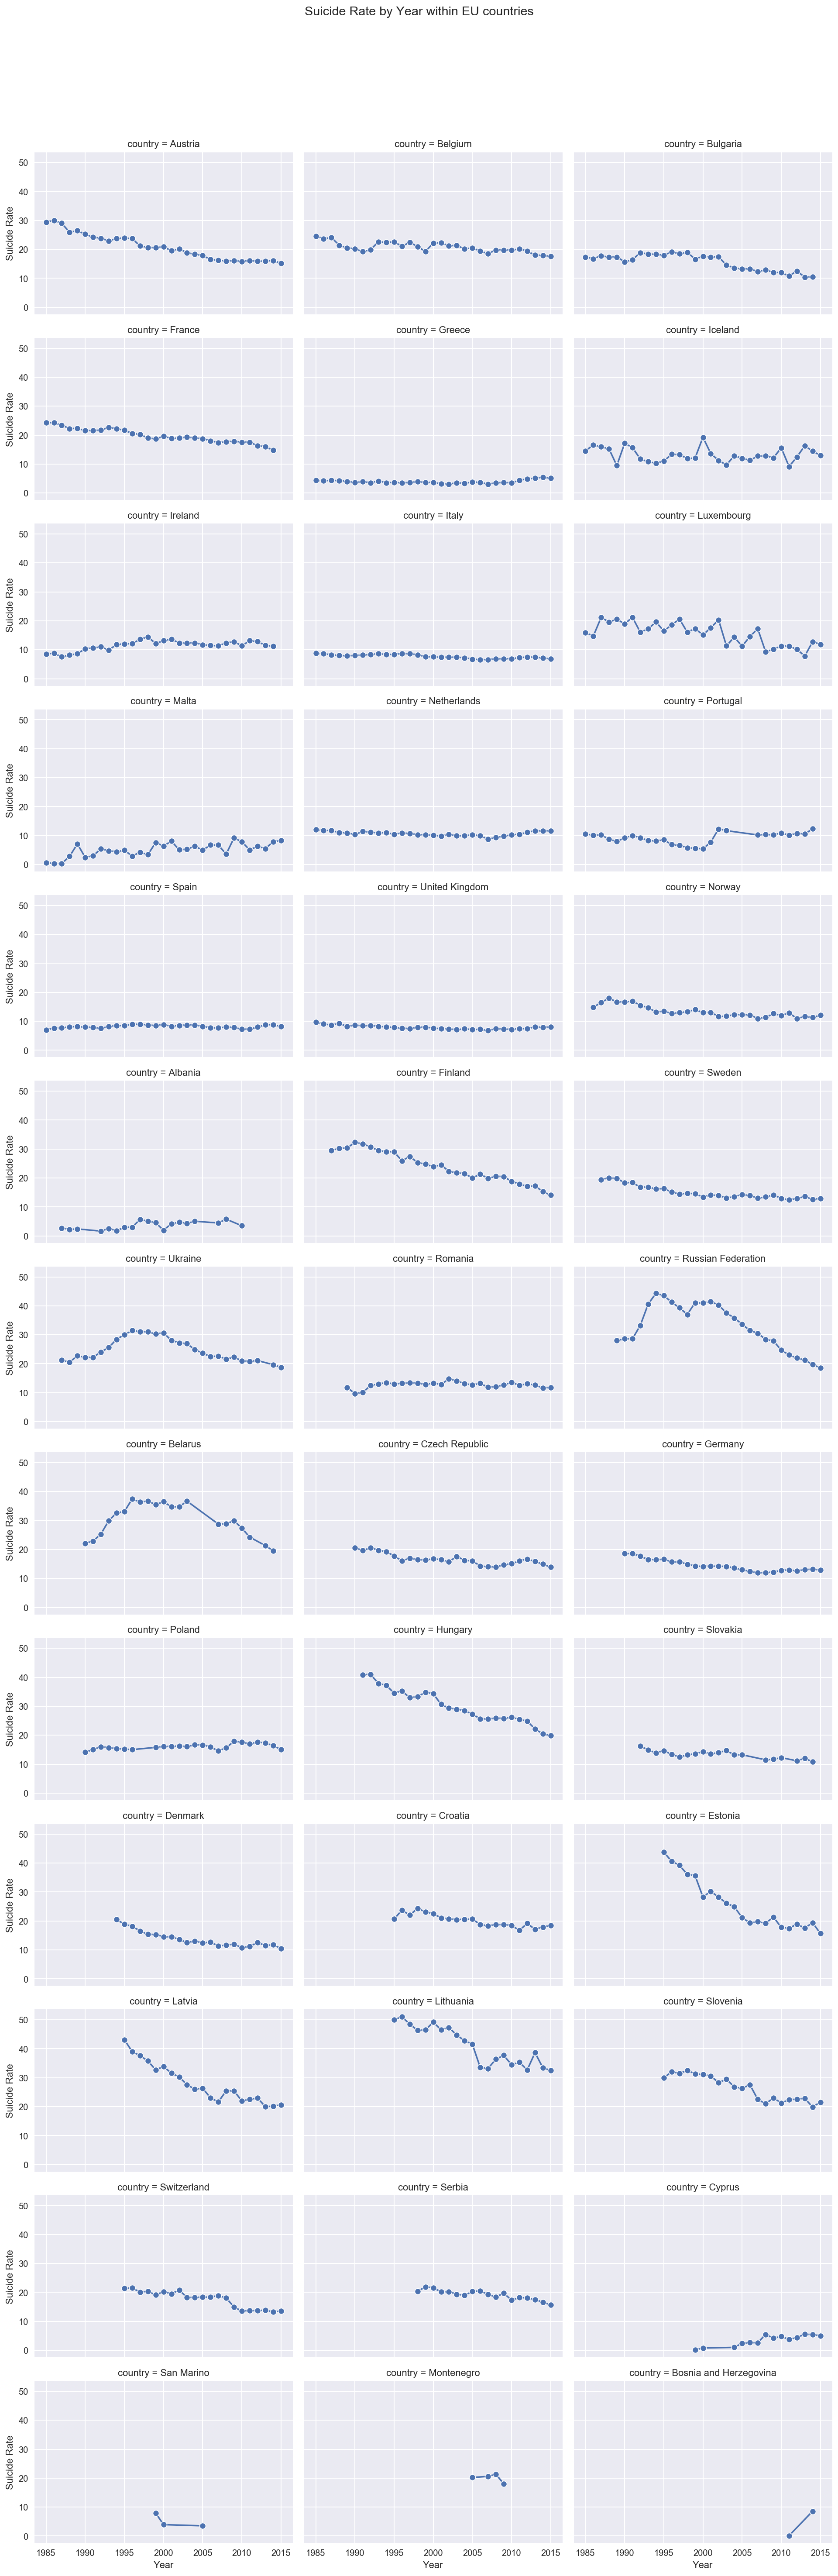

In [60]:
europe = dataset[dataset.continent == 'Europe'].groupby(['year','country'])[['total_suicides','population']]\
.sum().fillna(0).reset_index()
europe['suicide_rate'] = europe['total_suicides']*100000/europe['population'] #suicide rate: base on 100K

filtered_eu = europe.drop(europe.index[ (europe.total_suicides == 0) |  (europe.population == 0) ])
#plotting
sns.set_style("darkgrid")
ax = sns.relplot(x="year", y="suicide_rate", col="country",col_wrap=3,
                 data=filtered_eu , kind="line", legend="full", marker='o',
                height=3, aspect=1.5)
ax.set(ylabel='Suicide Rate', xlabel='Year')
ax.fig.suptitle('Suicide Rate by Year within EU countries', x=0.5, y=1.05)
plt.show()

**Observation**:<br> 
- Considering suicide rate above 20(per 100k) to be alarming (assumption) some of the countries which require special attention:<br>
Ukraine, Russia, Hungary, Belarus,Lithuania, Hungary <br>
- Suicide in Lithuania has become a significant social issue in the country due to its high rate. Despite constantly decreasing since its peak in 1995, the suicide rate in Lithuania remains the highest in the EU. The suicide rate as of 2017 is 26.4 suicides per 100,000 people


### 4. Analysis of suicide rate by gender

Note: This is infact the most interesting part of our study. Before conducting the analysis we thought suicide rate for women will be higher than men but the data has a different story to tell!

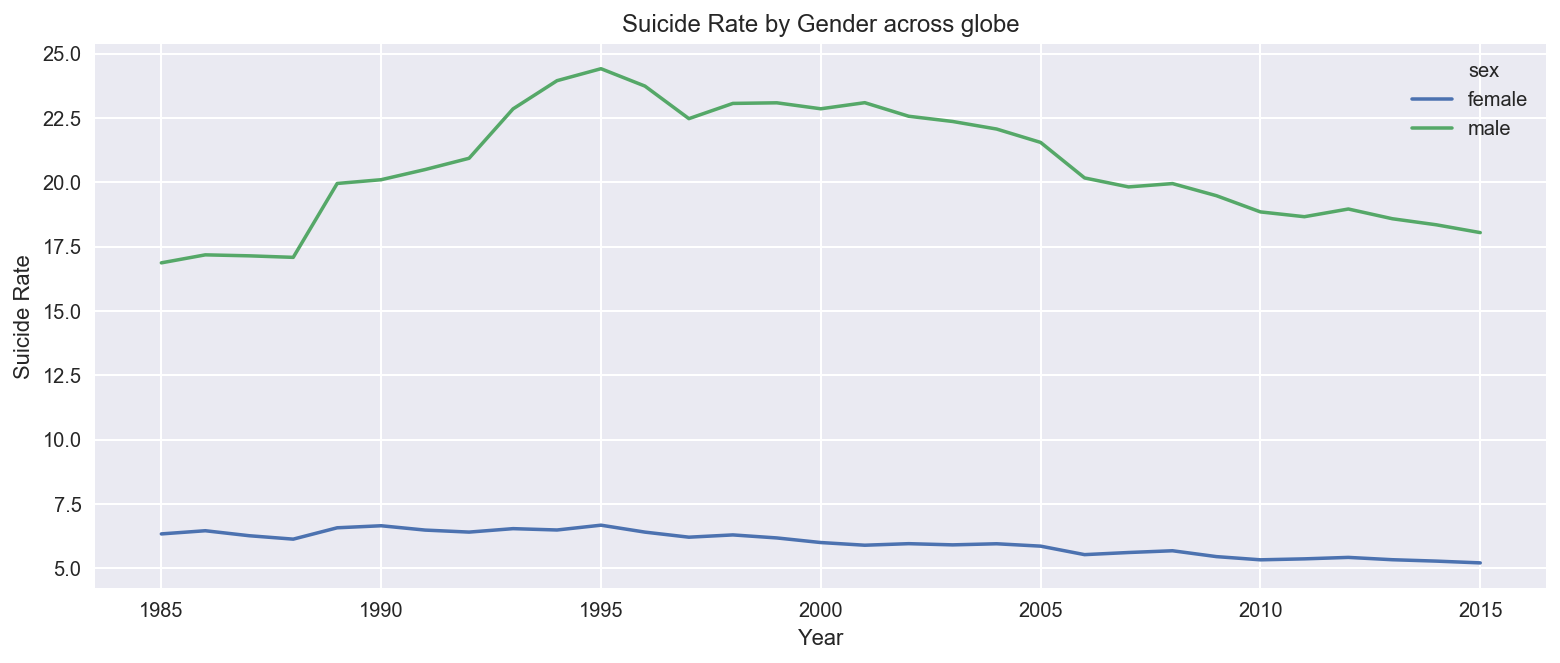

In [61]:
#1-2_1. Suicide rate by genders-overall
plt.figure(figsize=(13,5))
by_year = dataset.groupby(['year','sex'])[['population','total_suicides']].sum().reset_index()
by_year['suicide_rate'] = by_year['total_suicides']*100000/by_year['population']
ax = sns.lineplot(x="year", y="suicide_rate",hue = 'sex',data=by_year,  legend="full")
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Suicide Rate by Gender across globe')
plt.show()

**Observation:** <br>
- The difference in suicide rate per 100k people is nearly 11.2% more for men as compared to women in 2015 <br>
- Also the rate is pretty consistent for women whereas there is a steep increase in the suicide rate for men from 1990 to 1995

## 5. Analaysis of suicide rate by gender and continent

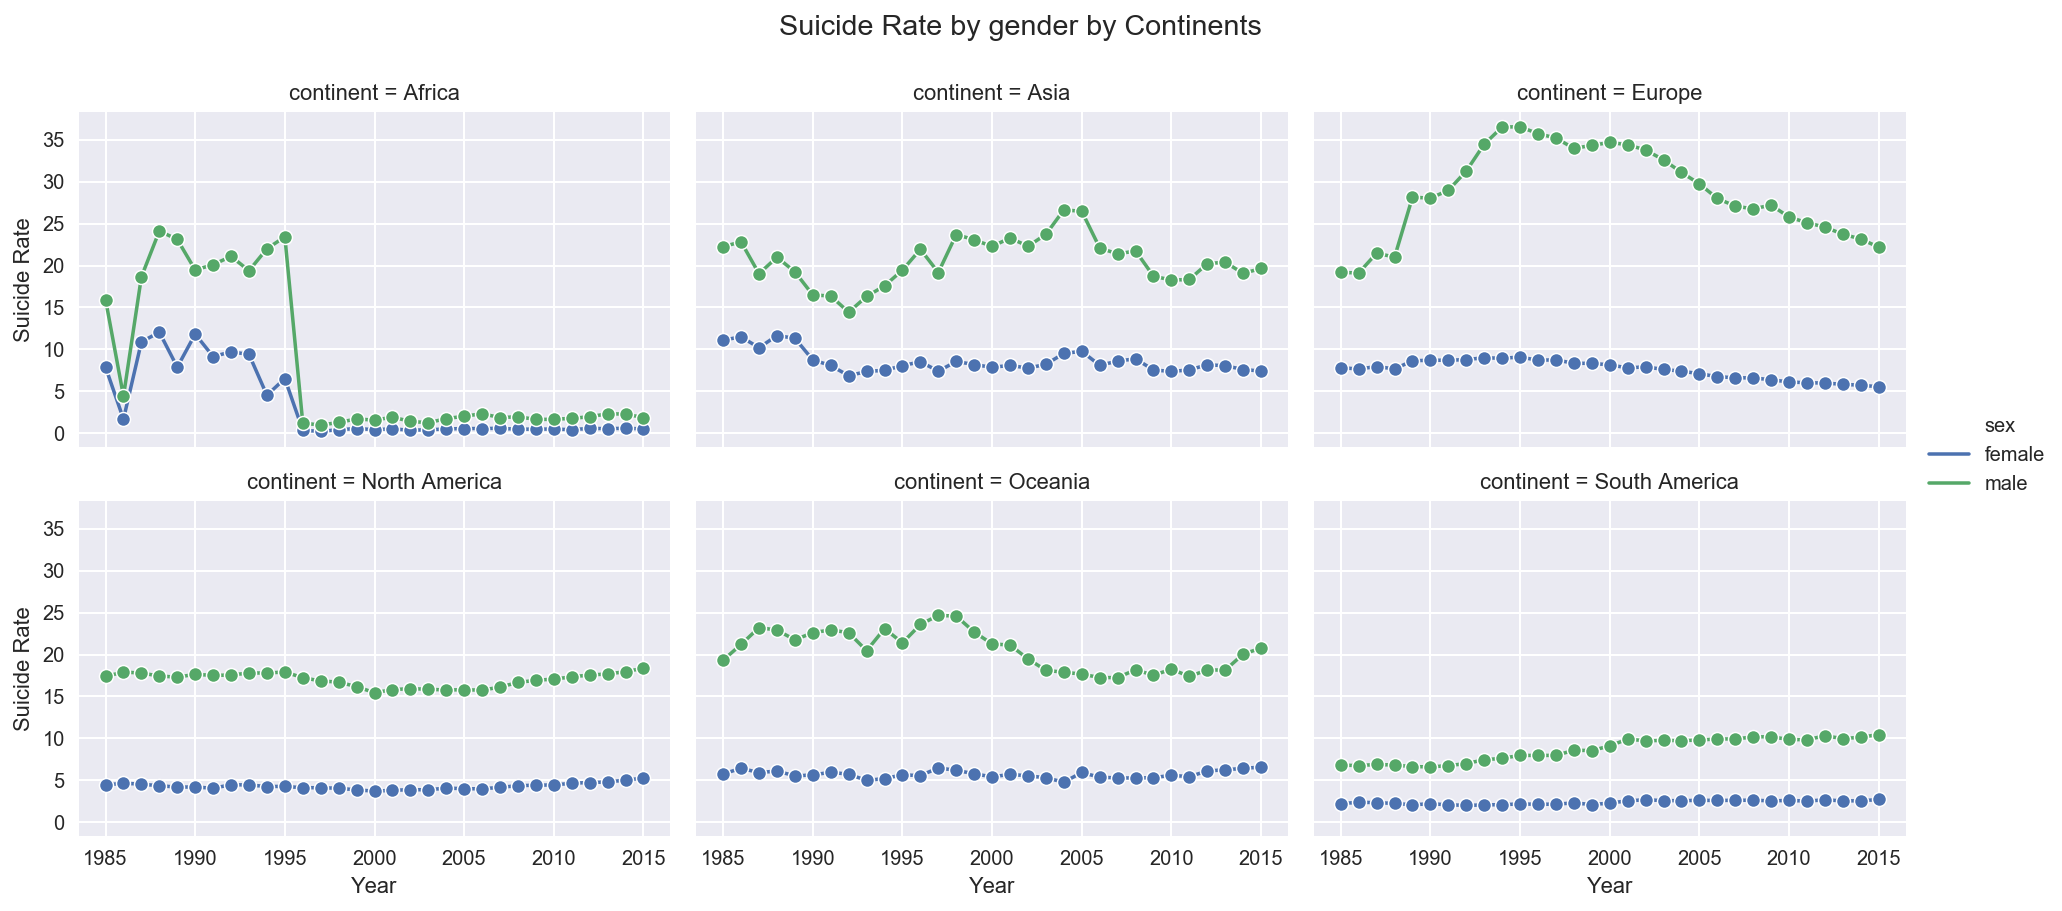

In [62]:
#1-2_2. Suicide rate by genders-by continent
by_region = dataset.groupby(['year','continent','sex'])[['population','total_suicides']].sum().reset_index()
by_region['suicide_rate'] = by_region['total_suicides']*100000/by_region['population']

sns.set_style("darkgrid")
ax = sns.relplot(x="year", y="suicide_rate", col="continent", hue='sex', col_wrap=3,
                 data=by_region , kind="line", legend="full", marker='o',
                height=3, aspect=1.5)
ax.set(ylabel='Suicide Rate', xlabel='Year')
ax.fig.suptitle('Suicide Rate by gender by Continents', x=0.5, y=1.05)
plt.show()

**Observation:**
- Separating between different continents, the rates of male suicide rates in Europe are linked to the combined trend of overall male suicide rates.
- The peak rate of male suicide rates in the EU was set in 1995, incorporating results from the continent of Europe's previous analysis
- Also the suicide rate for women is pretty consistent across all continents

### 6. Analysis of suicide rate By Age Groups

Note: This is the second most interesting part of our study since we thought tennagers/working adults commit the most suicide but ...

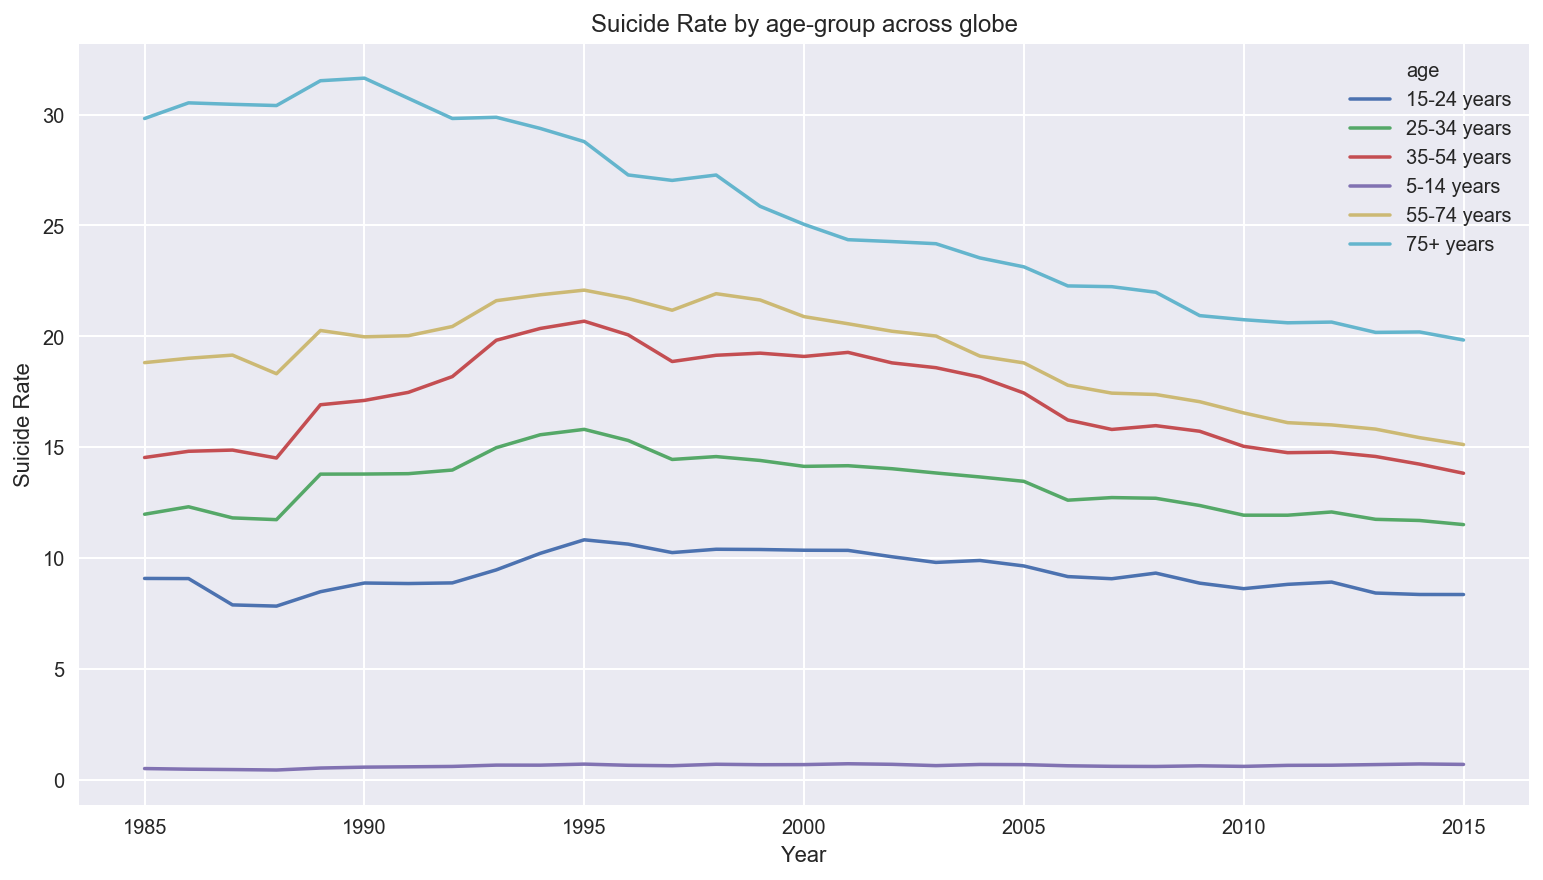

In [63]:
#1-3_1. Suicide rate by age groups
plt.figure(figsize=(13,7))
by_year = dataset.groupby(['year','age'])[['population','total_suicides']].sum().reset_index()
by_year['suicide_rate'] = by_year['total_suicides']*100000/by_year['population']
ax = sns.lineplot(x="year", y="suicide_rate",hue = 'age',data=by_year,  legend="full")
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Suicide Rate by age-group across globe')
plt.show()

**Observation:** <br>
- The suicide rate for adults aged 75+ years is much higher than any other age group
- It also seems that there is a higher tendency to commit suicide as you grow older!

## 7. Is GDP related to suicide?

Note: We personally think this is an interesting question because the general expectation would be that higher GDP leads to more inflow of money inside the country but it seems money is not the answer to all of our problems..

The below EDA has been done on Tableau 

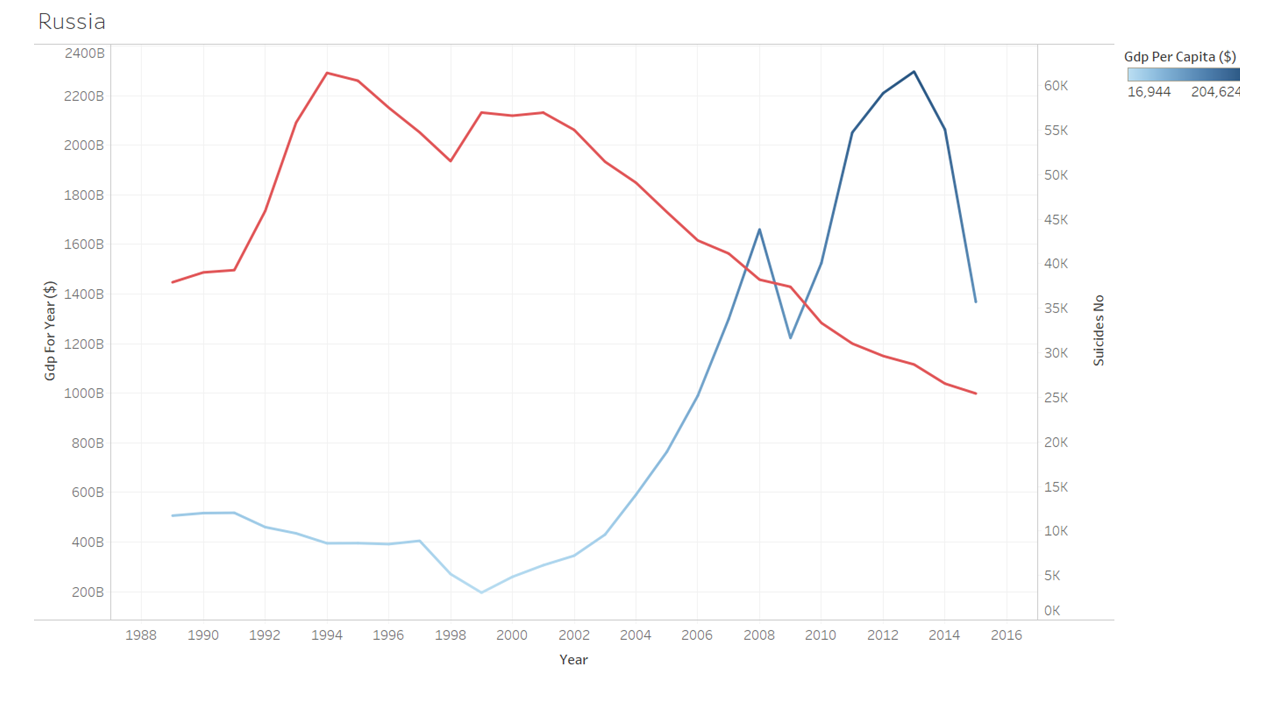

In [64]:
from IPython.display import Image
Image(filename='img/russia.png',height=800,width=800)

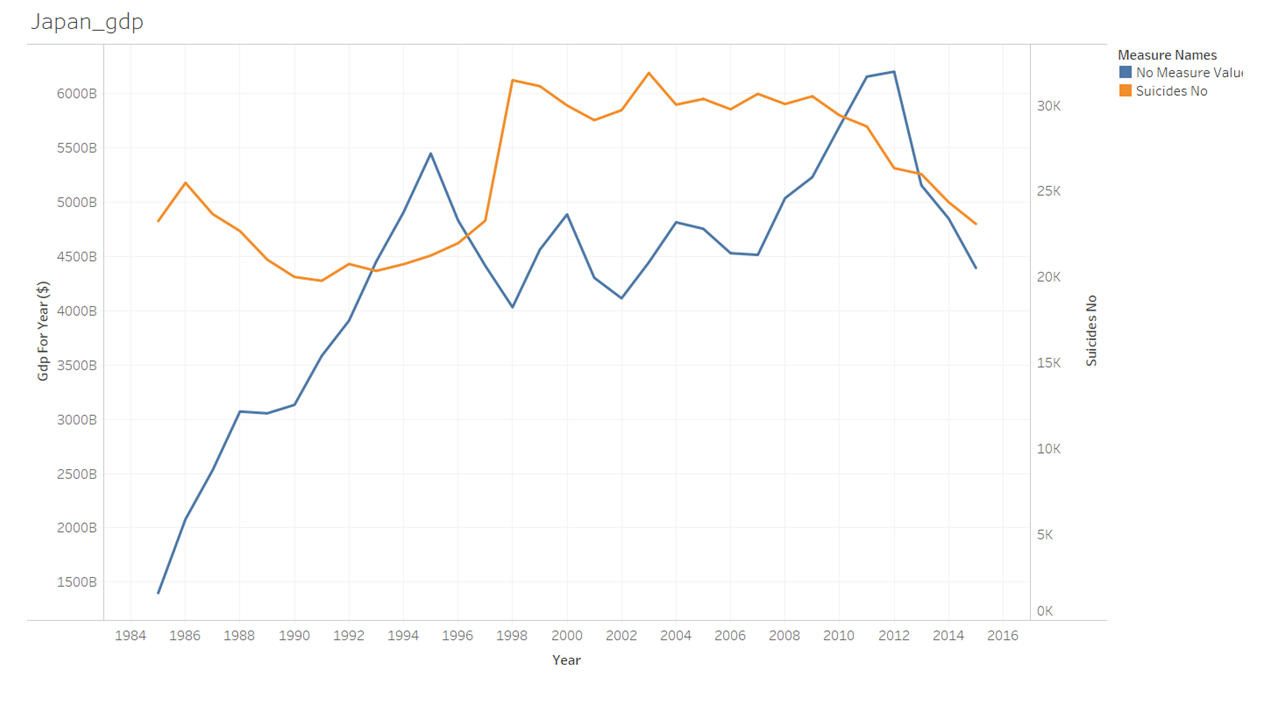

In [65]:
from IPython.display import Image
Image(filename='img/japan.png',height=800,width=800)

**Observation**:
The graphs above show that as GDP increases suicide rates decrease and as GDP decreases suicide rates increase which at par to our assumption before starting our analysis

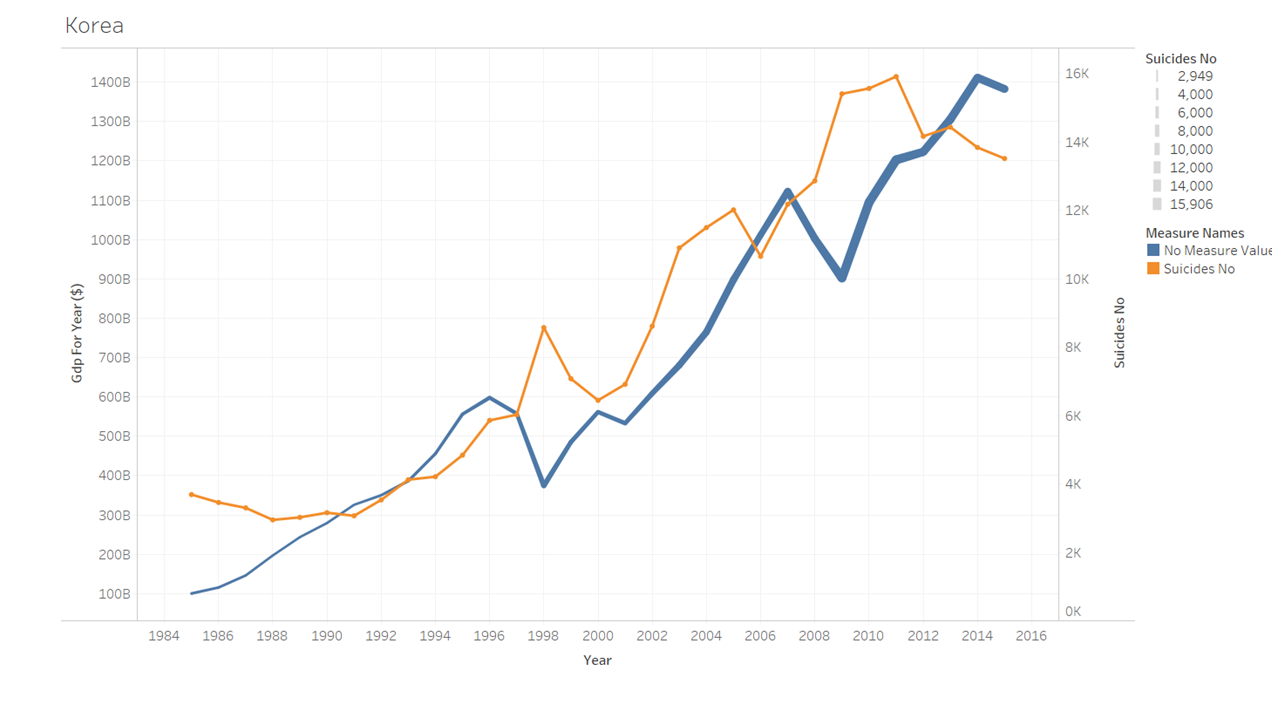

In [66]:
from IPython.display import Image
Image(filename='img/korea.png',height=800,width=800)

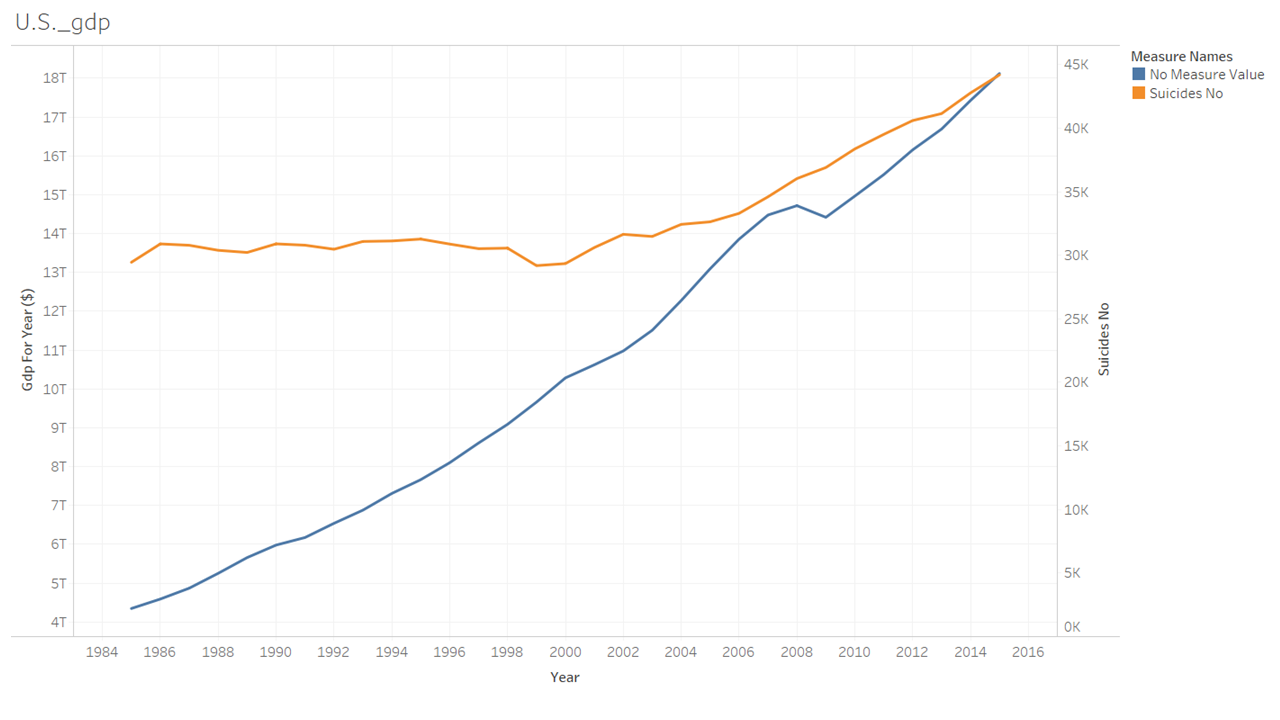

In [67]:
from IPython.display import Image
Image(filename='img/us.png',height=800,width=800)

**Observation**:
However, these graphs shows that even if GDP is increasing in both Korea and USA, the suicide rate is also increasing

**Overall observation**: Since some countries show negative correlation between GDP and suicide rate whereas some countries have a positive correlation between GDP and suicide rate we can't say for sure if GDP impacts suicide rate